In [462]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin

In [494]:
df = pd.read_csv("dropoffs_df.csv", parse_dates=["delivery_timestamp"])

In [495]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   client_name                9000 non-null   object        
 1   truck_size                 9000 non-null   object        
 2   truck_origin_warehouse     9000 non-null   object        
 3   delivery_timestamp         9000 non-null   datetime64[ns]
 4   total_weight               9000 non-null   float64       
 5   brand_1_coffee_proportion  9000 non-null   float64       
 6   driver_id                  9000 non-null   object        
 7   is_fresh_client            9000 non-null   bool          
 8   postcode                   9000 non-null   int64         
 9   business_category          9000 non-null   object        
 10  floor                      9000 non-null   object        
 11  partnership_level          9000 non-null   object        
 12  box_co

In [496]:
df.head()

,client_name,truck_size,truck_origin_warehouse,delivery_timestamp,total_weight,brand_1_coffee_proportion,driver_id,is_fresh_client,postcode,business_category,floor,partnership_level,box_count,brand_2_coffee_proportion,brand_3_coffee_proportion,final_time
0,Amigó Ltd,Van,Baró de Viver,2022-04-28 18:56:43,9.86,0.85,D84,False,8030,Cafe/Restaurant,Street level,Regular,2,0.003478,0.146522,231.423355
1,Amigó Ltd,Van,Baró de Viver,2022-02-25 20:32:46,83.91,0.55,D84,False,8030,Cafe/Restaurant,Street level,Regular,10,0.362871,0.087129,366.285832
2,Amigó Ltd,Van,Baró de Viver,2022-03-25 13:11:07,25.45,0.65,D84,False,8030,Cafe/Restaurant,Street level,Regular,3,0.118100,0.231900,222.254702
3,Amigó Ltd,Truck,Zona Franca,2022-01-20 19:00:59,115.89,0.49,D84,False,8030,Cafe/Restaurant,Street level,Regular,13,0.140500,0.369500,665.148256
4,Gutiérrez LLC,Van,Baró de Viver,2022-04-23 08:40:26,107.64,0.76,D84,False,8002,Hotels,Ground Floor,Key Account,14,0.182975,0.057025,988.631435


In [497]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.2, random_state=352)

In [498]:
data = train.copy()

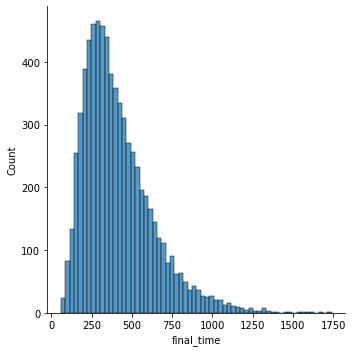

In [151]:
sns.displot(data.final_time)

In [50]:
data.groupby("driver_id")[["box_count", "total_weight", "final_time"]].apply(np.mean)

# Because the box count and total weight are similar for all drivers, driver_id might be a determinant of final_time

,box_count,total_weight,final_time
driver_id,,,
D13,7.452975,62.594453,550.465743
D16,7.130350,60.709553,496.741638
D18,7.309751,61.940803,456.882773
D27,7.429368,63.643401,458.643355
D33,7.194286,61.700590,285.065113
D49,7.311304,61.879496,370.271240
D58,7.338798,63.836357,442.046233
D61,7.594340,62.943943,395.577473
D63,7.758993,64.710144,618.702507


In [51]:
# Sanity check for outliers in total_weight and box count

pd.concat([data.total_weight.describe(), data.box_count.describe()], axis=1)

,total_weight,box_count
count,7200.000000,7200.000000
mean,62.811904,7.401806
std,32.935406,4.419938
min,5.000000,1.000000
25%,34.680000,4.000000
50%,62.600000,7.000000
75%,91.370000,10.000000
max,120.000000,24.000000


<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


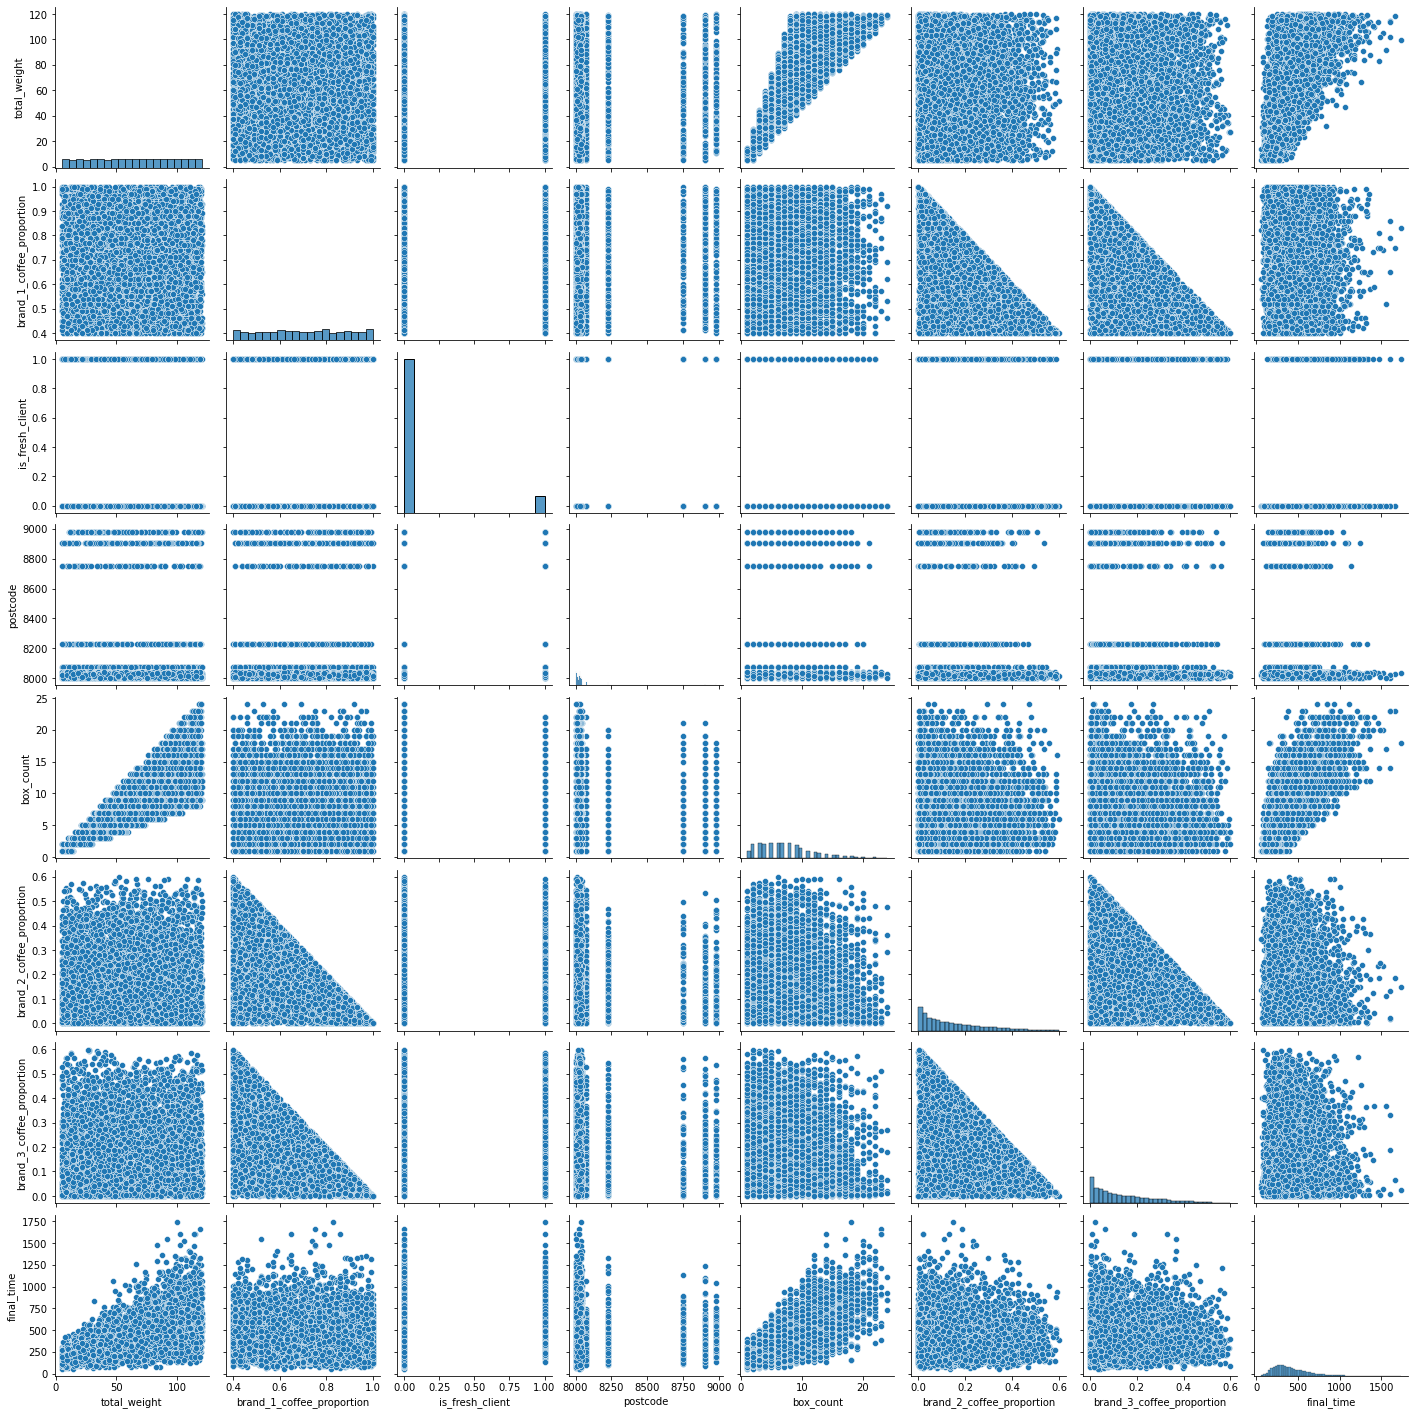

In [52]:
sns.pairplot(data)

In [53]:
data.corr()["final_time"].sort_values(ascending=False)

final_time                   1.000000
box_count                    0.736523
total_weight                 0.603160
is_fresh_client              0.191238
brand_1_coffee_proportion    0.006490
postcode                    -0.001394
brand_3_coffee_proportion   -0.002564
brand_2_coffee_proportion   -0.006015
Name: final_time, dtype: float64

In [54]:
ab = pd.DataFrame([data.final_time, data.delivery_timestamp.dt.hour]).T

In [55]:
data["hour_delivery"] = data.delivery_timestamp.dt.hour

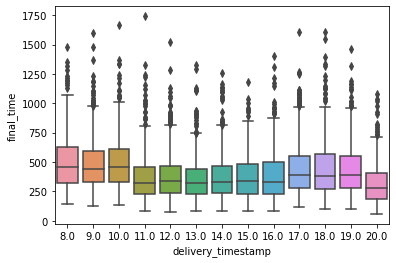

In [56]:
sns.boxplot(x = "delivery_timestamp", y = "final_time", data = ab);

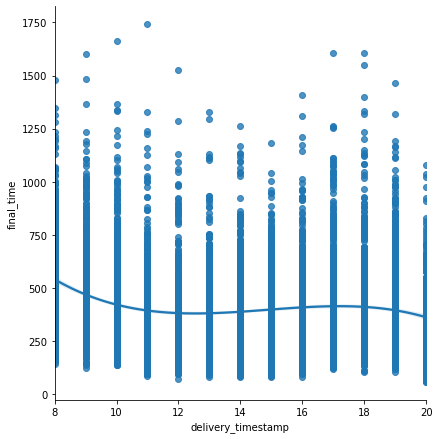

In [57]:
sns.lmplot(x = "delivery_timestamp", y = "final_time", data = ab, y_jitter=.1, order = 3, height = 6);

In [1426]:
mae3 = np.abs((data['final_time'] - (60*3))).mean()
mae3

240.49134752166518

In [1692]:
np.abs((data['final_time'] - data.final_time.quantile(0.5))).describe()

count    7200.000000
mean      161.785905
std       151.213738
min         0.118598
25%        61.266262
50%       125.716606
75%       208.236340
max      1375.145571
Name: final_time, dtype: float64

In [1425]:
mse_mean = np.abs((data['final_time'] - data.final_time.quantile(0.5))).mean()
mse_mean

161.78590455414025

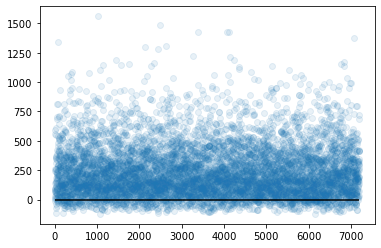

In [1424]:
plt.scatter(range(0, data.shape[0]), data.final_time - 180, alpha=0.1)
plt.hlines(0, xmin=0, xmax=data.shape[0], colors="black")

In [1483]:
aa = data.final_time - data.final_time.quantile(0.5)

In [1513]:
tracking_ml = []
subtracking_ml = []
max_uniform = len(aa)
predictions = np.exp(forest_reg.predict(X))
errors = (predictions - np.exp(y[0]))

for i in range(0, 80):
    for j in range(0, 3000):
        selection = np.int32(np.random.uniform(0, max_uniform, i))
        subtracking_ml.append(errors[selection].sum())
    tracking_ml.append(np.array(subtracking_ml).mean())
    subtracking_ml = []

Text(0, 0.5, 'cumulative error in minutes')

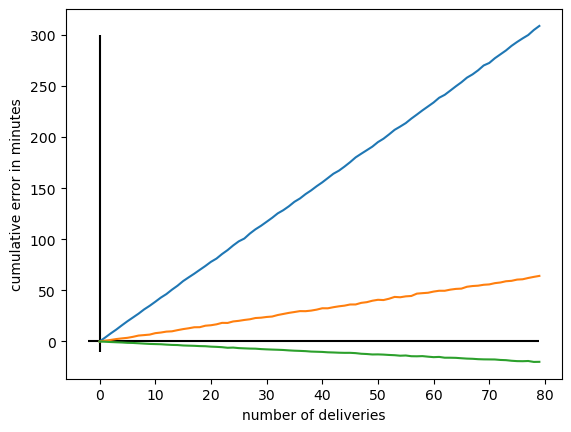

In [1551]:
plt.plot(np.array(tracking3) / 60)
plt.plot(np.array(tracking_med) / 60)
plt.plot(np.array(tracking_ml) / 60)
plt.hlines(0, xmin = -2, xmax = 79, colors = "black")
plt.vlines(0, ymin = -10, ymax = 300, colors = "black")
plt.xlabel("number of deliveries")
plt.ylabel("cumulative error in minutes")

In [1534]:
pd.DataFrame([tracking3, tracking_med, tracking_ml]).T.iloc[range(10,80, 10), :] / 60

,0,1,2
10,38.838381,8.141117,-2.537846
20,77.912745,15.891304,-5.044268
30,117.076209,23.977614,-7.696880
40,155.672755,32.503825,-10.209264
50,195.043995,40.785375,-12.619359
60,233.804547,48.834383,-15.317033
70,272.478704,55.843483,-17.540810


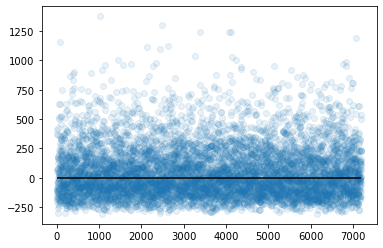

In [1428]:
plt.scatter(range(0, data.shape[0]), data.final_time - data.final_time.quantile(0.5), alpha=0.1)
plt.hlines(0, xmin=0, xmax=data.shape[0], colors="black")

In [60]:
data["day_of_week"] = data.delivery_timestamp.dt.day_name()
data.head()

,client_name,truck_size,truck_origin_warehouse,delivery_timestamp,total_weight,brand_1_coffee_proportion,driver_id,is_fresh_client,postcode,business_category,floor,partnership_level,box_count,brand_2_coffee_proportion,brand_3_coffee_proportion,final_time,hour_delivery,day_of_week
7082,"Llorens, Mayo and Gallardo",Van,Zona Franca,2022-03-27 16:36:44,50.23,0.93,D49,False,8017,Cafe/Restaurant,Street level,Key Account,9,0.007570,0.062430,271.719554,16,Sunday
4364,Montenegro LLC,Combi,Baró de Viver,2022-05-11 15:11:18,24.62,0.79,D61,False,8031,Cafe/Restaurant,Street level,Regular,2,0.089182,0.120818,166.447019,15,Wednesday
903,Larrea Ltd,Combi,Baró de Viver,2022-03-18 18:27:08,88.51,0.69,D98,False,8023,Cafe/Restaurant,Street level,Key Account,9,0.073709,0.236291,319.324676,18,Friday
1782,Carbó-Pineda,Van,Baró de Viver,2022-01-29 08:57:02,28.16,0.43,D98,False,8039,Cafe/Restaurant,Street level,Regular,2,0.496380,0.073620,207.010109,8,Saturday
8456,Belmonte-Leal,Combi,Zona Franca,2022-04-11 12:19:00,110.26,0.40,D33,False,8009,Cafe/Restaurant,Street level,Key Account,9,0.188679,0.411321,260.611064,12,Monday


<AxesSubplot:xlabel='day_of_week', ylabel='final_time'>

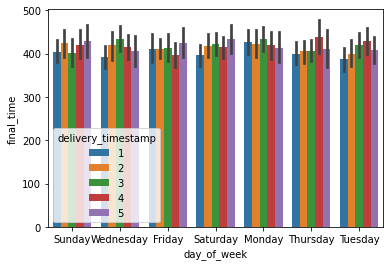

In [61]:
sns.barplot(data = data, x = "day_of_week", y = "final_time", hue = data.delivery_timestamp.dt.month)
# No difference in the day of the week, nor the month

In [62]:
aa = pd.concat([data.groupby("client_name")["final_time"].mean(), data.groupby("client_name")["final_time"].count()], axis=1)
aa.to_csv("final_time_por_cliente.csv")

In [338]:
sns.lmplot(data = data, x = "hour_delivery", y= "final_time", hue = "is_fresh_client", col = "is_fresh_client", scatter_kws={'alpha':0.1})

KeyError: "['hour_delivery'] not in index"

In [64]:
data

,client_name,truck_size,truck_origin_warehouse,delivery_timestamp,total_weight,brand_1_coffee_proportion,driver_id,is_fresh_client,postcode,business_category,floor,partnership_level,box_count,brand_2_coffee_proportion,brand_3_coffee_proportion,final_time,hour_delivery,day_of_week
7082,"Llorens, Mayo and Gallardo",Van,Zona Franca,2022-03-27 16:36:44,50.23,0.93,D49,False,8017,Cafe/Restaurant,Street level,Key Account,9,0.007570,0.062430,271.719554,16,Sunday
4364,Montenegro LLC,Combi,Baró de Viver,2022-05-11 15:11:18,24.62,0.79,D61,False,8031,Cafe/Restaurant,Street level,Regular,2,0.089182,0.120818,166.447019,15,Wednesday
903,Larrea Ltd,Combi,Baró de Viver,2022-03-18 18:27:08,88.51,0.69,D98,False,8023,Cafe/Restaurant,Street level,Key Account,9,0.073709,0.236291,319.324676,18,Friday
1782,Carbó-Pineda,Van,Baró de Viver,2022-01-29 08:57:02,28.16,0.43,D98,False,8039,Cafe/Restaurant,Street level,Regular,2,0.496380,0.073620,207.010109,8,Saturday
8456,Belmonte-Leal,Combi,Zona Franca,2022-04-11 12:19:00,110.26,0.40,D33,False,8009,Cafe/Restaurant,Street level,Key Account,9,0.188679,0.411321,260.611064,12,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756,"Herrera, Juliá and Gabaldón",Van,Zona Franca,2022-02-14 19:25:57,92.05,0.48,D13,True,8036,Cafe/Restaurant,Street level,Regular,10,0.427147,0.092853,902.768493,19,Monday
3035,Valero Ltd,Truck,Baró de Viver,2022-04-11 12:05:30,67.68,0.94,D13,False,8038,Cafe/Restaurant,Ground Floor,Regular,8,0.033147,0.026853,473.258479,12,Monday
1987,Rico PLC,Combi,Zona Franca,2022-02-11 10:26:20,101.72,1.00,D98,False,8017,Hotels,Ground Floor,Regular,12,0.000000,0.000000,594.233117,10,Friday
1440,Alberola-Alcaraz,Truck,Baró de Viver,2022-01-10 10:18:00,51.29,0.66,D98,False,8012,Coffee Retailers,Ground Floor,Key Account,7,0.217748,0.122252,312.748144,10,Monday


<AxesSubplot:>

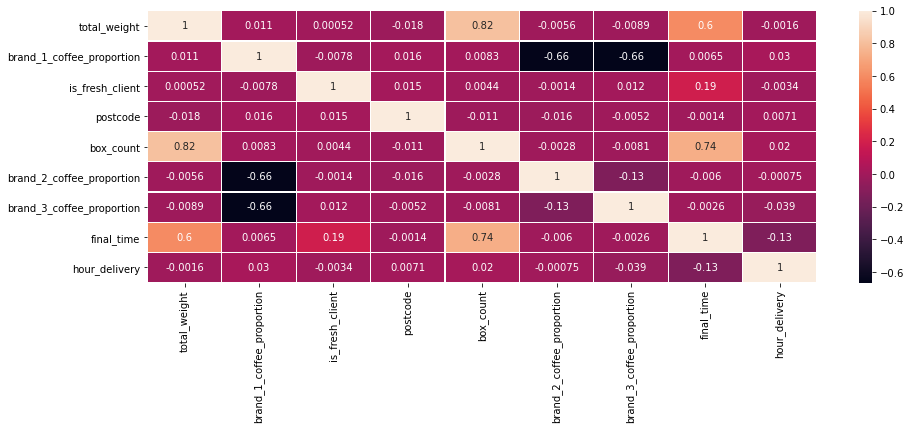

In [65]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(data.corr(), annot=True, linewidths = 0.3)

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7200 entries, 7082 to 3174
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   client_name                7200 non-null   object        
 1   truck_size                 7200 non-null   object        
 2   truck_origin_warehouse     7200 non-null   object        
 3   delivery_timestamp         7200 non-null   datetime64[ns]
 4   total_weight               7200 non-null   float64       
 5   brand_1_coffee_proportion  7200 non-null   float64       
 6   driver_id                  7200 non-null   object        
 7   is_fresh_client            7200 non-null   bool          
 8   postcode                   7200 non-null   int64         
 9   business_category          7200 non-null   object        
 10  floor                      7200 non-null   object        
 11  partnership_level          7200 non-null   object        
 12  box

In [67]:
#categorical_variables = data[[list(data.select_dtypes(include=['object']).columns)][0]]
categorical_variables = data[['truck_size', 'truck_origin_warehouse', 'driver_id','business_category', 'floor', 'partnership_level']]
cat_encoder = OneHotEncoder(sparse=False)
data_encoded = cat_encoder.fit_transform(categorical_variables)
cat_encoder.categories_

[array(['Combi', 'Truck', 'Van'], dtype=object),
 array(['Baró de Viver', 'Zona Franca'], dtype=object),
 array(['D13', 'D16', 'D18', 'D27', 'D33', 'D49', 'D58', 'D61', 'D63',
        'D64', 'D84', 'D9', 'D98'], dtype=object),
 array(['Cafe/Restaurant', 'Coffee Retailers', 'Hotels'], dtype=object),
 array(['Ground Floor', 'Other', 'Street level'], dtype=object),
 array(['Diamond', 'Key Account', 'Regular'], dtype=object)]

In [68]:
list_1D = [j for sub in cat_encoder.categories_ for j in sub]

In [69]:
data_encoded = pd.DataFrame(data_encoded, index = data.index)
data_encoded.columns = list_1D
data_encoded

,Combi,Truck,Van,Baró de Viver,Zona Franca,D13,D16,D18,D27,D33,...,D98,Cafe/Restaurant,Coffee Retailers,Hotels,Ground Floor,Other,Street level,Diamond,Key Account,Regular
7082,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4364,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
903,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1782,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8456,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3035,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1987,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1440,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [70]:
all_training_data = pd.concat([data, data_encoded], axis = 1)

In [71]:
all_training_data

,client_name,truck_size,truck_origin_warehouse,delivery_timestamp,total_weight,brand_1_coffee_proportion,driver_id,is_fresh_client,postcode,business_category,...,D98,Cafe/Restaurant,Coffee Retailers,Hotels,Ground Floor,Other,Street level,Diamond,Key Account,Regular
7082,"Llorens, Mayo and Gallardo",Van,Zona Franca,2022-03-27 16:36:44,50.23,0.93,D49,False,8017,Cafe/Restaurant,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4364,Montenegro LLC,Combi,Baró de Viver,2022-05-11 15:11:18,24.62,0.79,D61,False,8031,Cafe/Restaurant,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
903,Larrea Ltd,Combi,Baró de Viver,2022-03-18 18:27:08,88.51,0.69,D98,False,8023,Cafe/Restaurant,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1782,Carbó-Pineda,Van,Baró de Viver,2022-01-29 08:57:02,28.16,0.43,D98,False,8039,Cafe/Restaurant,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8456,Belmonte-Leal,Combi,Zona Franca,2022-04-11 12:19:00,110.26,0.40,D33,False,8009,Cafe/Restaurant,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756,"Herrera, Juliá and Gabaldón",Van,Zona Franca,2022-02-14 19:25:57,92.05,0.48,D13,True,8036,Cafe/Restaurant,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3035,Valero Ltd,Truck,Baró de Viver,2022-04-11 12:05:30,67.68,0.94,D13,False,8038,Cafe/Restaurant,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1987,Rico PLC,Combi,Zona Franca,2022-02-11 10:26:20,101.72,1.00,D98,False,8017,Hotels,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1440,Alberola-Alcaraz,Truck,Baró de Viver,2022-01-10 10:18:00,51.29,0.66,D98,False,8012,Coffee Retailers,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [72]:
all_training_data.corr()["final_time"].sort_values()

D98                         -0.255535
Street level                -0.170576
D33                         -0.167331
hour_delivery               -0.130350
Combi                       -0.070974
D49                         -0.059614
D61                         -0.024030
Zona Franca                 -0.010195
Coffee Retailers            -0.007102
brand_2_coffee_proportion   -0.006015
Key Account                 -0.002580
brand_3_coffee_proportion   -0.002564
postcode                    -0.001394
Hotels                      -0.000322
Regular                     -0.000195
D84                          0.000228
D9                           0.000384
Cafe/Restaurant              0.005679
brand_1_coffee_proportion    0.006490
Diamond                      0.008754
Baró de Viver                0.010195
D64                          0.028813
Van                          0.033605
D58                          0.037290
Truck                        0.041243
D18                          0.055541
D27         

<AxesSubplot:xlabel='final_time', ylabel='floor'>

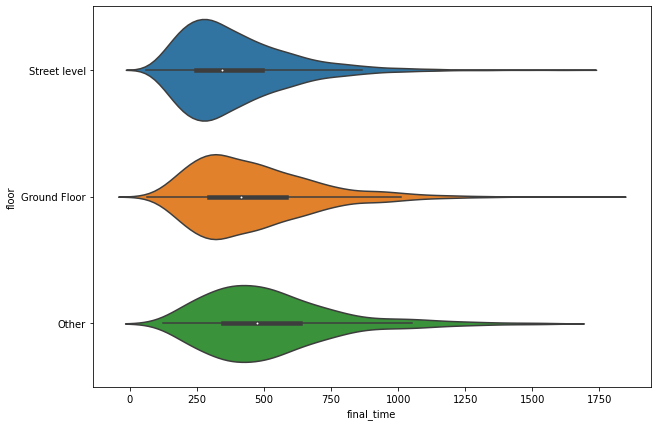

In [73]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.violinplot(y = data.floor, x = data.final_time)

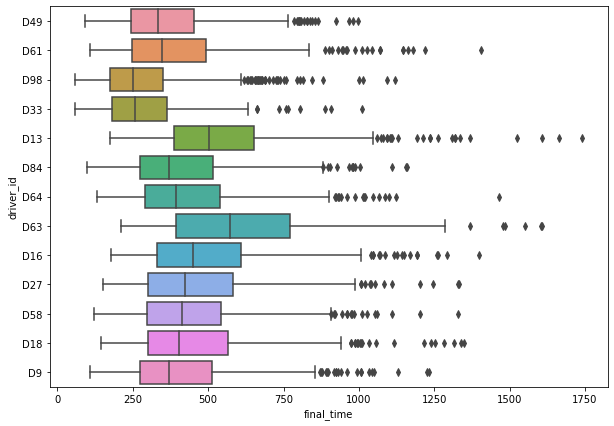

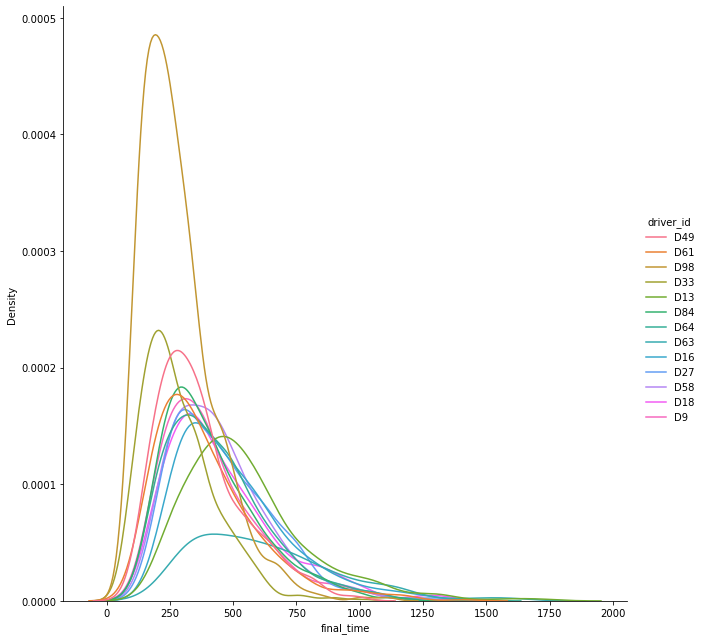

In [557]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(y = data.driver_id, x = data.final_time)
sns.displot(data, x="final_time", hue="driver_id", height=9, kind="kde")

<AxesSubplot:xlabel='box_count', ylabel='driver_id'>

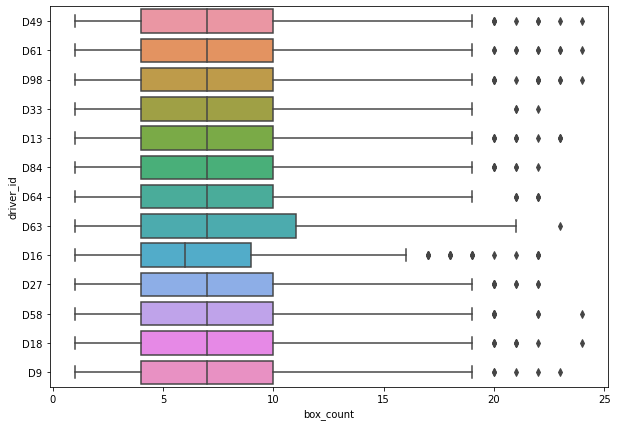

In [75]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(y = data.driver_id, x = data.box_count)

<AxesSubplot:xlabel='final_time', ylabel='partnership_level'>

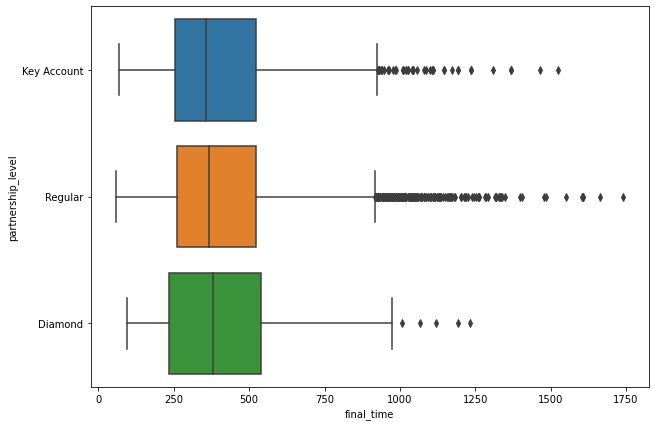

In [76]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(y = data.partnership_level, x = data.final_time)

<AxesSubplot:xlabel='final_time', ylabel='truck_size'>

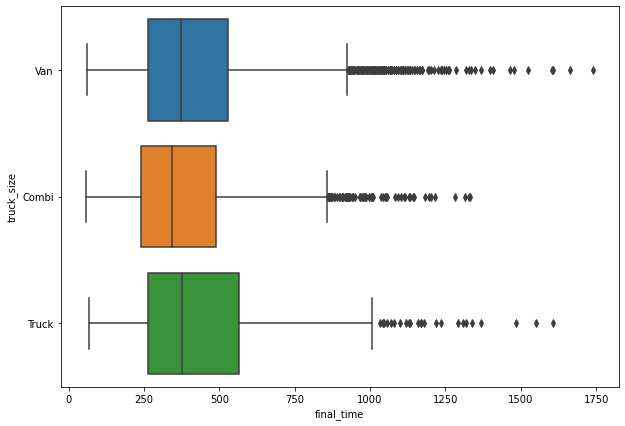

In [77]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(y = data.truck_size, x = data.final_time)

<AxesSubplot:xlabel='final_time', ylabel='business_category'>

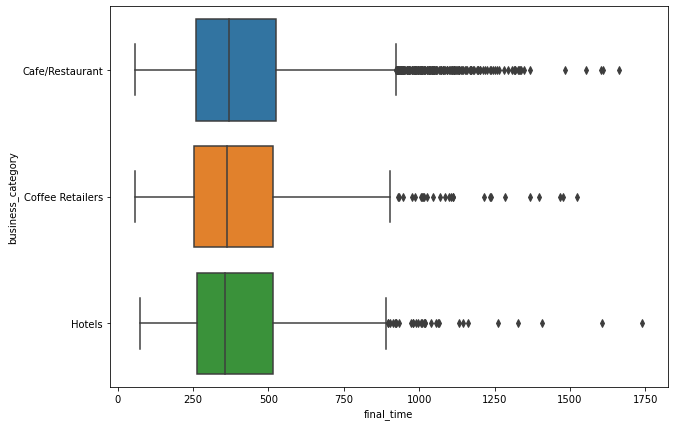

In [78]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(y = data.business_category, x = data.final_time)

In [79]:
data.groupby("driver_id")[["box_count", "total_weight"]].apply(np.mean)

,box_count,total_weight
driver_id,,
D13,7.452975,62.594453
D16,7.130350,60.709553
D18,7.309751,61.940803
D27,7.429368,63.643401
D33,7.194286,61.700590
D49,7.311304,61.879496
D58,7.338798,63.836357
D61,7.594340,62.943943
D63,7.758993,64.710144


In [80]:
# lists the categorical variables
list(data.select_dtypes(include=['object']).columns)

['client_name',
 'truck_size',
 'truck_origin_warehouse',
 'driver_id',
 'business_category',
 'floor',
 'partnership_level',
 'day_of_week']

In [81]:
data.select_dtypes(include=['object']).columns

Index(['client_name', 'truck_size', 'truck_origin_warehouse', 'driver_id',
       'business_category', 'floor', 'partnership_level', 'day_of_week'],
      dtype='object')

In [82]:
list(data.select_dtypes(include=['datetime64']).columns)

['delivery_timestamp']

# Transformers

In [1635]:
## Custom transformers
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, hour_granularity = True, log_final_time = True, final_time_in_seconds = True):
        self.hour_granularity = hour_granularity
        self.log_final_time = log_final_time
        self.final_time_in_seconds = final_time_in_seconds

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        if self.hour_granularity:
            X["hour_delivery"] = X["delivery_timestamp"].dt.hour
        if self.final_time_in_seconds:
            X["final_time"] = round(X["final_time"], 0)
        if self.log_final_time:
            X["final_time"] = np.log(X["final_time"])
        return X

#####################

class OnehotWithColnames(BaseEstimator, TransformerMixin):
    def __init__(self, onehot = True, dummy_enc = False, cat_variables = ['truck_size', 'driver_id', 'floor', 'is_fresh_client']):
        self.onehot = onehot
        self.cat_variables = cat_variables
        self.dummy_enc = dummy_enc

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        if self.onehot:
            categorical_variables = X[self.cat_variables]
            if self.dummy_enc:
                cat_encoder = OneHotEncoder(sparse = False)
            else:
                cat_encoder = OneHotEncoder(sparse = False, drop = "first")
            data_encoded = cat_encoder.fit_transform(categorical_variables)
            list_1D = [j for sub in cat_encoder.categories_ for j in sub]
            data_encoded = pd.DataFrame(data_encoded, index = X.index)
            data_encoded.columns = list_1D
            X = pd.concat([X, data_encoded], axis = 1)
            pd.DataFrame(X)
            X = X.drop(categorical_variables, axis=1)
        return pd.DataFrame(X)

#####################

class DropFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, categoricals = True, timestamps = True):
        self.categoricals = categoricals
        self.timestamps = timestamps

    def fit(self, X):
        return self

    def transform(self, X, y = None):
        if self.categoricals:
            X = X.drop(list(X.select_dtypes(include=['object']).columns), axis = 1)
        if self.timestamps:
            X = X.drop(list(X.select_dtypes(include=['datetime64']).columns), axis = 1)
        return X

#####################

class SanityCheck():
    def __init__(self, model, seconds = True):
        self.model = model
        self.seconds = seconds

        if self.seconds:
            self.errors = pd.DataFrame(np.exp(self.model.predict(X)) - np.exp(y)[0])
        else:
            self.errors = pd.DataFrame(self.model.predict(X) - y[0])


    def plot_errors(self, absolute_errors = False):
        self.absolute_errors = absolute_errors

        if self.absolute_errors:
            self.errors = np.abs(self.errors)

        rounded_prepared_cols = np.int32(np.ceil(data_prepared.shape[1]/3))
        fig, ax = plt.subplots(nrows = rounded_prepared_cols,
                               ncols = 3,
                               sharey='all',
                               gridspec_kw = dict(left=0.1, right=0.9, bottom=0.1, top=5.5),
                               figsize=(15, 5))
        i = 0

        for row in range(0, rounded_prepared_cols):
            for col in range(0, 3):
                if i < data_prepared.shape[1]:
                    ax[row, col].scatter(data_prepared.iloc[:,i], self.errors, alpha = 0.1)
                    ax[row, col].hlines(y = 0, xmin = data_prepared.iloc[:,i].min(), xmax = data_prepared.iloc[:,i].max(), colors="black", alpha = 0.5)
                    if self.absolute_errors:
                        ax[row, col].hlines(y = self.errors.mean(), xmin = data_prepared.iloc[:,i].min(), xmax = data_prepared.iloc[:,i].max(), colors="green", alpha = 0.8)
                    a, b = np.polyfit(data_prepared.iloc[:,i], self.errors, 1)
                    ax[row, col].plot(data_prepared.iloc[:,i], a*data_prepared.iloc[:,i]+b, color = "red")
                    ax[row, col].set_title(f"distribution of errors relative to {data_prepared.columns[i]}")
                    i += 1
        plt.show()

In [1292]:
data2 = data.copy()

aa = OnehotWithColnames().transform(data2)
aa

,client_name,truck_origin_warehouse,delivery_timestamp,total_weight,brand_1_coffee_proportion,postcode,business_category,partnership_level,box_count,brand_2_coffee_proportion,...,D63,D64,D84,D9,D98,Ground Floor,Other,Street level,False,True
7082,"Llorens, Mayo and Gallardo",Zona Franca,2022-03-27 16:36:44,50.23,0.93,8017,Cafe/Restaurant,Key Account,9,0.007570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4364,Montenegro LLC,Baró de Viver,2022-05-11 15:11:18,24.62,0.79,8031,Cafe/Restaurant,Regular,2,0.089182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
903,Larrea Ltd,Baró de Viver,2022-03-18 18:27:08,88.51,0.69,8023,Cafe/Restaurant,Key Account,9,0.073709,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1782,Carbó-Pineda,Baró de Viver,2022-01-29 08:57:02,28.16,0.43,8039,Cafe/Restaurant,Regular,2,0.496380,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
8456,Belmonte-Leal,Zona Franca,2022-04-11 12:19:00,110.26,0.40,8009,Cafe/Restaurant,Key Account,9,0.188679,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756,"Herrera, Juliá and Gabaldón",Zona Franca,2022-02-14 19:25:57,92.05,0.48,8036,Cafe/Restaurant,Regular,10,0.427147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3035,Valero Ltd,Baró de Viver,2022-04-11 12:05:30,67.68,0.94,8038,Cafe/Restaurant,Regular,8,0.033147,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1987,Rico PLC,Zona Franca,2022-02-11 10:26:20,101.72,1.00,8017,Hotels,Regular,12,0.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1440,Alberola-Alcaraz,Baró de Viver,2022-01-10 10:18:00,51.29,0.66,8012,Coffee Retailers,Key Account,7,0.217748,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


## Pipeline

In [ ]:
num_pipeline = Pipeline([
    ("custom_transformer", CustomTransformer(log_final_time=True,
                                            hour_granularity=True,
                                            final_time_in_seconds=True)),
    ("drop_features_num", DropFeatures(categoricals = True,
                                       timestamps = True))
])

In [367]:
cat_pipeline = Pipeline([
    ("Onehot", OnehotWithColnames()),
    ("drop_features_cat", DropFeatures(categoricals = False,
                                       timestamps = False))
])

In [1293]:
#variables_to_encode = ['truck_size', 'truck_origin_warehouse', 'driver_id','business_category', 'floor', 'partnership_level']

variables_to_encode = ['truck_size', 'driver_id', 'floor', 'is_fresh_client']
numerical_variables = ['total_weight', 'box_count', 'final_time', 'delivery_timestamp']

data2 = data.copy()

full_pipeline = ColumnTransformer([
    ("categorical", cat_pipeline, variables_to_encode),
    ("numerical", num_pipeline, numerical_variables),
])

data2.head()

,client_name,truck_size,truck_origin_warehouse,delivery_timestamp,total_weight,brand_1_coffee_proportion,driver_id,is_fresh_client,postcode,business_category,floor,partnership_level,box_count,brand_2_coffee_proportion,brand_3_coffee_proportion,final_time
7082,"Llorens, Mayo and Gallardo",Van,Zona Franca,2022-03-27 16:36:44,50.23,0.93,D49,False,8017,Cafe/Restaurant,Street level,Key Account,9,0.007570,0.062430,271.719554
4364,Montenegro LLC,Combi,Baró de Viver,2022-05-11 15:11:18,24.62,0.79,D61,False,8031,Cafe/Restaurant,Street level,Regular,2,0.089182,0.120818,166.447019
903,Larrea Ltd,Combi,Baró de Viver,2022-03-18 18:27:08,88.51,0.69,D98,False,8023,Cafe/Restaurant,Street level,Key Account,9,0.073709,0.236291,319.324676
1782,Carbó-Pineda,Van,Baró de Viver,2022-01-29 08:57:02,28.16,0.43,D98,False,8039,Cafe/Restaurant,Street level,Regular,2,0.496380,0.073620,207.010109
8456,Belmonte-Leal,Combi,Zona Franca,2022-04-11 12:19:00,110.26,0.40,D33,False,8009,Cafe/Restaurant,Street level,Key Account,9,0.188679,0.411321,260.611064


In [1587]:
tracking_columns = []
for i in ['truck_size', 'driver_id', 'floor', 'is_fresh_client']:
    tracking_columns.append(list(data[i].value_counts().index))

In [1588]:
tracking_columns.append(['total_weight', 'box_count', 'final_time', 'delivery_timestamp'])
tracking_columns

[['Van', 'Combi', 'Truck'],
 ['D98',
  'D49',
  'D58',
  'D27',
  'D64',
  'D61',
  'D84',
  'D33',
  'D18',
  'D13',
  'D16',
  'D9',
  'D63'],
 ['Street level', 'Ground Floor', 'Other'],
 [False, True],
 ['total_weight', 'box_count', 'final_time', 'delivery_timestamp']]

In [1591]:
columns_1d = [j for sub in tracking_columns for j in sub]
columns_1d

['Van',
 'Combi',
 'Truck',
 'D98',
 'D49',
 'D58',
 'D27',
 'D64',
 'D61',
 'D84',
 'D33',
 'D18',
 'D13',
 'D16',
 'D9',
 'D63',
 'Street level',
 'Ground Floor',
 'Other',
 False,
 True,
 'total_weight',
 'box_count',
 'final_time',
 'delivery_timestamp']

In [1605]:
new_columns_1d = []
for i in columns_1d:
    new_columns_1d.append(str(i))

In [1606]:
data_prepared = pd.DataFrame(data_prepared)
data_prepared.columns = new_columns_1d
data_prepared

,Van,Combi,Truck,D98,D49,D58,D27,D64,D61,D84,...,D63,Street level,Ground Floor,Other,False,True,total_weight,box_count,final_time,delivery_timestamp
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,50.23,9.0,5.605802,16.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,24.62,2.0,5.111988,15.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,88.51,9.0,5.765191,18.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,28.16,2.0,5.332719,8.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,110.26,9.0,5.564520,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,92.05,10.0,6.805723,19.0
7196,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,67.68,8.0,6.159095,12.0
7197,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,101.72,12.0,6.386879,10.0
7198,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,51.29,7.0,5.746203,10.0


### Decision Tree Classifier

In [1238]:
num_pipeline = Pipeline([
    ("custom_transformer", CustomTransformer(log_final_time=True,
                                            hour_granularity=True,
                                            final_time_in_seconds=True)),
    ("drop_features_num", DropFeatures(categoricals = True,
                                       timestamps = True))
])

cat_pipeline = Pipeline([
    ("Onehot", OnehotWithColnames()),
    ("drop_features_cat", DropFeatures(categoricals = False,
                                       timestamps = False))
])

data2 = data.copy()

full_pipeline = ColumnTransformer([
    ("categorical", cat_pipeline, variables_to_encode),
    ("numerical", num_pipeline, numerical_variables),
])

data_prepared = full_pipeline.fit_transform(data2)

In [1320]:
data3 = data.copy()

cat_pipeline.transform(data3)
num_pipeline.transform(data3)

,total_weight,brand_1_coffee_proportion,is_fresh_client,postcode,box_count,brand_2_coffee_proportion,brand_3_coffee_proportion,final_time,hour_delivery
7082,50.23,0.93,False,8017,9,0.007570,0.062430,5.605802,16
4364,24.62,0.79,False,8031,2,0.089182,0.120818,5.111988,15
903,88.51,0.69,False,8023,9,0.073709,0.236291,5.765191,18
1782,28.16,0.43,False,8039,2,0.496380,0.073620,5.332719,8
8456,110.26,0.40,False,8009,9,0.188679,0.411321,5.564520,12
...,...,...,...,...,...,...,...,...,...
2756,92.05,0.48,True,8036,10,0.427147,0.092853,6.805723,19
3035,67.68,0.94,False,8038,8,0.033147,0.026853,6.159095,12
1987,101.72,1.00,False,8017,12,0.000000,0.000000,6.386879,10
1440,51.29,0.66,False,8012,7,0.217748,0.122252,5.746203,10


In [1596]:
pd.DataFrame(data_prepared).head()

,Van,Combi,Truck,D98,D49,D58,D27,D64,D61,D84,...,D63,Street level,Ground Floor,Other,False,True,total_weight,box_count,final_time,delivery_timestamp
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,50.23,9.0,5.605802,16.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,24.62,2.0,5.111988,15.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,88.51,9.0,5.765191,18.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,28.16,2.0,5.332719,8.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,110.26,9.0,5.564520,12.0


In [1312]:
y = pd.DataFrame(data_prepared.iloc[:,23])
X = pd.DataFrame(np.delete(data_prepared, "final_time", axis = 1))

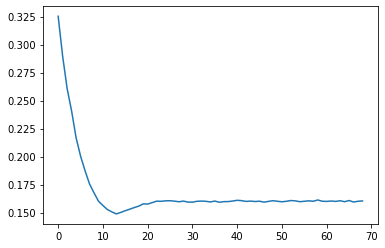

In [1242]:
tracking = []
for i in range(1, 70):
    tree_reg = DecisionTreeRegressor(max_depth = i)
    tree_reg.fit(X, y)
    scores = cross_val_score(tree_reg, X, y, scoring = "neg_mean_absolute_error", cv =  5)
    tracking.append(-scores.mean())

plt.plot(tracking)

In [1244]:
tree_reg = DecisionTreeRegressor(max_depth = 11)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=11)

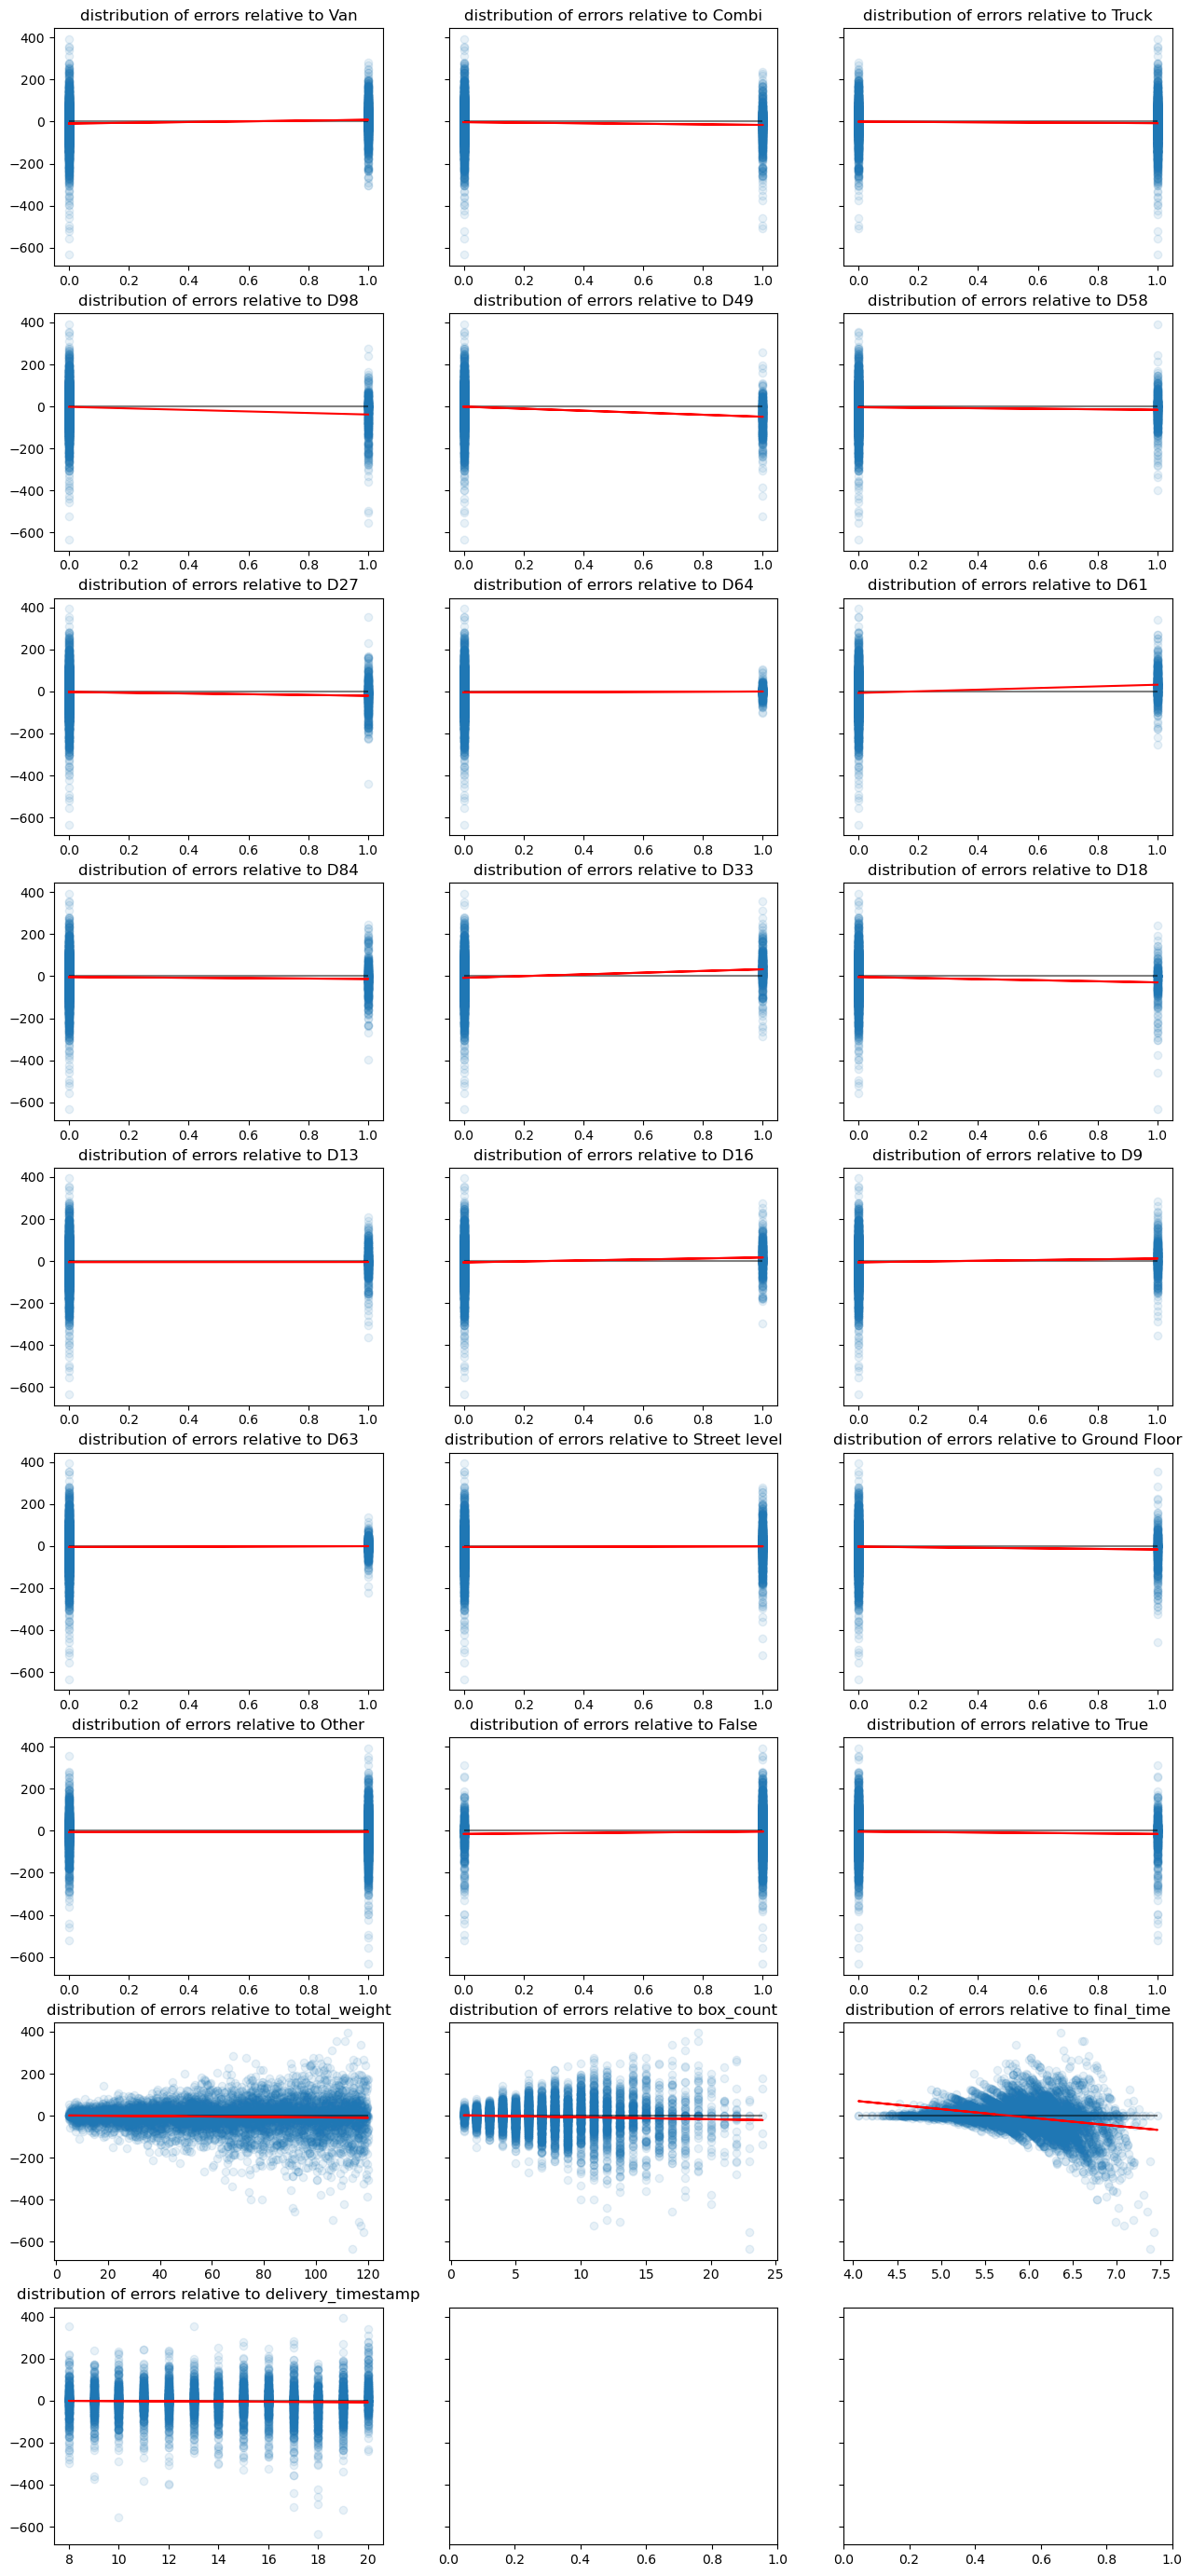

In [1636]:
SanityCheck(tree_reg).plot_errors()

In [1291]:
SanityCheck(tree_reg, seconds = True).errors.describe()

,0
count,7200.000000
mean,-4.654431
std,70.234592
min,-634.110109
25%,-29.377939
50%,0.000000
75%,26.217069
max,392.889891


### Regression Tree

In [1221]:
from sklearn.tree import DecisionTreeRegressor

y = all_training_data["final_time"]
X = all_training_data.drop(["final_time", "client_name", "truck_size", "truck_origin_warehouse", "driver_id", "postcode", "business_category", "floor", "partnership_level", "day_of_week", "delivery_timestamp", 'brand_1_coffee_proportion', 'brand_2_coffee_proportion', 'brand_3_coffee_proportion'], axis = 1)

In [1236]:
X

,total_weight,is_fresh_client,box_count,hour_delivery,Combi,Truck,Van,Baró de Viver,Zona Franca,D13,...,D98,Cafe/Restaurant,Coffee Retailers,Hotels,Ground Floor,Other,Street level,Diamond,Key Account,Regular
7082,50.23,False,9,16,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4364,24.62,False,2,15,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
903,88.51,False,9,18,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1782,28.16,False,2,8,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8456,110.26,False,9,12,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756,92.05,True,10,19,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3035,67.68,False,8,12,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1987,101.72,False,12,10,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1440,51.29,False,7,10,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


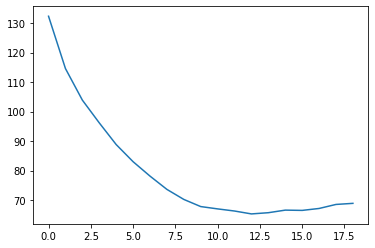

In [1234]:
tracking = []
for i in range(1, 20):
    tree_reg = DecisionTreeRegressor(max_depth = i).fit(X, y)
    tree_reg.fit(X, y)
    scores = cross_val_score(tree_reg, X, y, scoring = "neg_mean_absolute_error", cv =  5)
    tracking.append(-scores.mean())

plt.plot(tracking)

In [1235]:
tree_reg = DecisionTreeRegressor(criterion = "mae", max_depth = 12)
tree_reg.fit(X, y)

DecisionTreeRegressor(criterion='mae', max_depth=12)

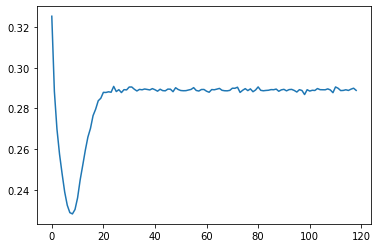

In [623]:
tracking = []
for i in range(1, 120):
    tree_reg = DecisionTreeRegressor(max_depth = i)
    tree_reg.fit(X, y)
    scores = cross_val_score(tree_reg, X, y, scoring = "neg_mean_absolute_error", cv =  5)
    tracking.append(-scores.mean())

plt.plot(tracking)

In [511]:
tree_reg.predict(X)

array([6.01375129, 5.26393226, 5.59226989, ..., 6.32307353, 5.77399276,
       5.9177219 ])

In [1330]:
SanityCheck(tree_reg, True).errors.describe()

,0
count,7200.000000
mean,-4.654431
std,70.234592
min,-634.110109
25%,-29.377939
50%,0.000000
75%,26.217069
max,392.889891


In [1365]:
class Simulation():
    def __init__(self, model, number_of_deliveries):
        self.model = model
        self.number_of_deliveries = number_of_deliveries
        data_length = X.shape[0] + 1

        self.daily_prediction = np.exp(self.model.predict(X.iloc[np.int32(np.random.uniform(0, data_length, number_of_deliveries)), :]))

In [1366]:
Simulation(model = tree_reg, number_of_deliveries = 20).daily_prediction

array([331.92390003, 278.64274349, 386.71383851, 508.        ,
       275.76162671, 344.16901454, 360.17739333, 337.52471277,
       331.92390003, 631.44260107, 392.01983834, 380.        ,
       400.78486658, 413.33142591, 591.5499184 , 256.04870323,
       242.08525107, 186.73305846, 256.04870323, 198.38400681])

### Random Forest Regressor

In [1315]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(criterion = "mae", max_depth=12, max_features="sqrt")
forest_reg.fit(X, y)

<ipython-input-1315-9c5e58561309>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_reg.fit(X, y)


RandomForestRegressor(criterion='mae', max_depth=12, max_features='sqrt')

In [1556]:
X.columns

RangeIndex(start=0, stop=24, step=1)

In [1610]:
colnames = data_prepared.drop("final_time", axis = 1).columns

In [1631]:
pd.DataFrame(forest_reg.feature_importances_, index = colnames).sort_values(by = 0, ascending=False)

,0
box_count,0.371695
total_weight,0.237275
delivery_timestamp,0.100564
D63,0.077585
D64,0.034706
Other,0.024495
D98,0.022006
True,0.018250
D18,0.018162
False,0.017292


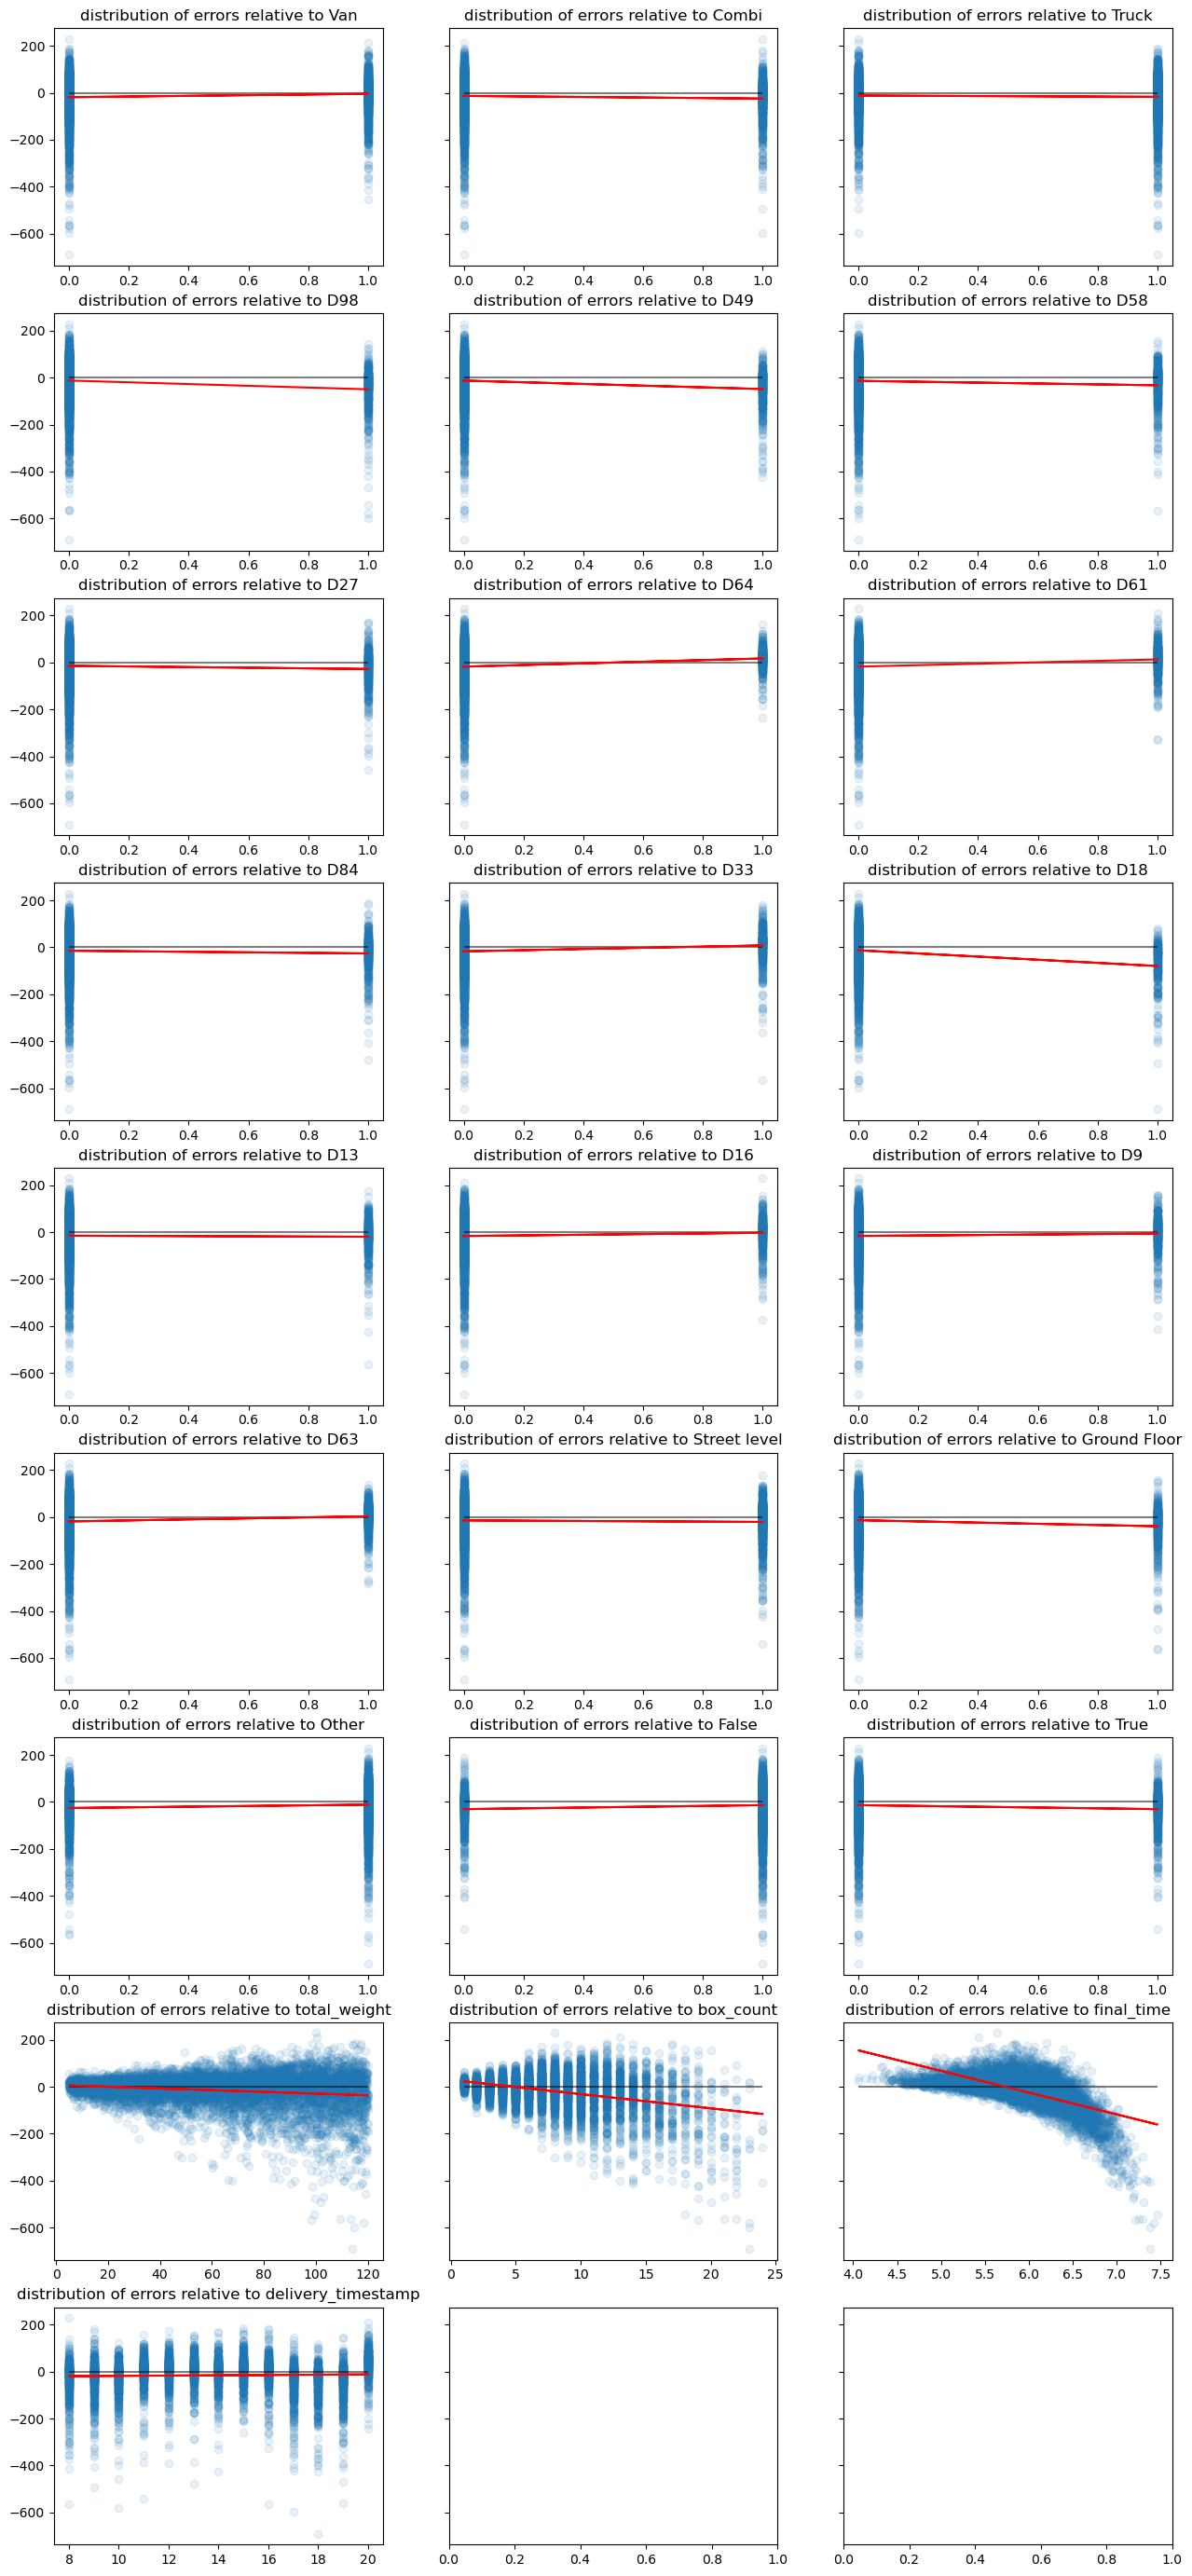

In [1637]:
SanityCheck(forest_reg, True).plot_errors()

### Polynomial

### SVM

In [1403]:
from sklearn import svm

svm_reg = svm.SVR()
svm_reg.fit(X, y)

/Users/marc/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVR()

In [1408]:
scores = cross_val_score(tree_reg, X, y, scoring = "neg_mean_absolute_error", cv =  5)
-scores.mean()

0.1554388741198399

In [1376]:
np.abs(np.exp(svm_reg.predict(X)) - np.exp(y[0])).describe()

count    7200.000000
mean       78.349922
std        75.490847
min         0.004699
25%        25.641907
50%        57.509675
75%       106.234988
max       744.681086
Name: 0, dtype: float64

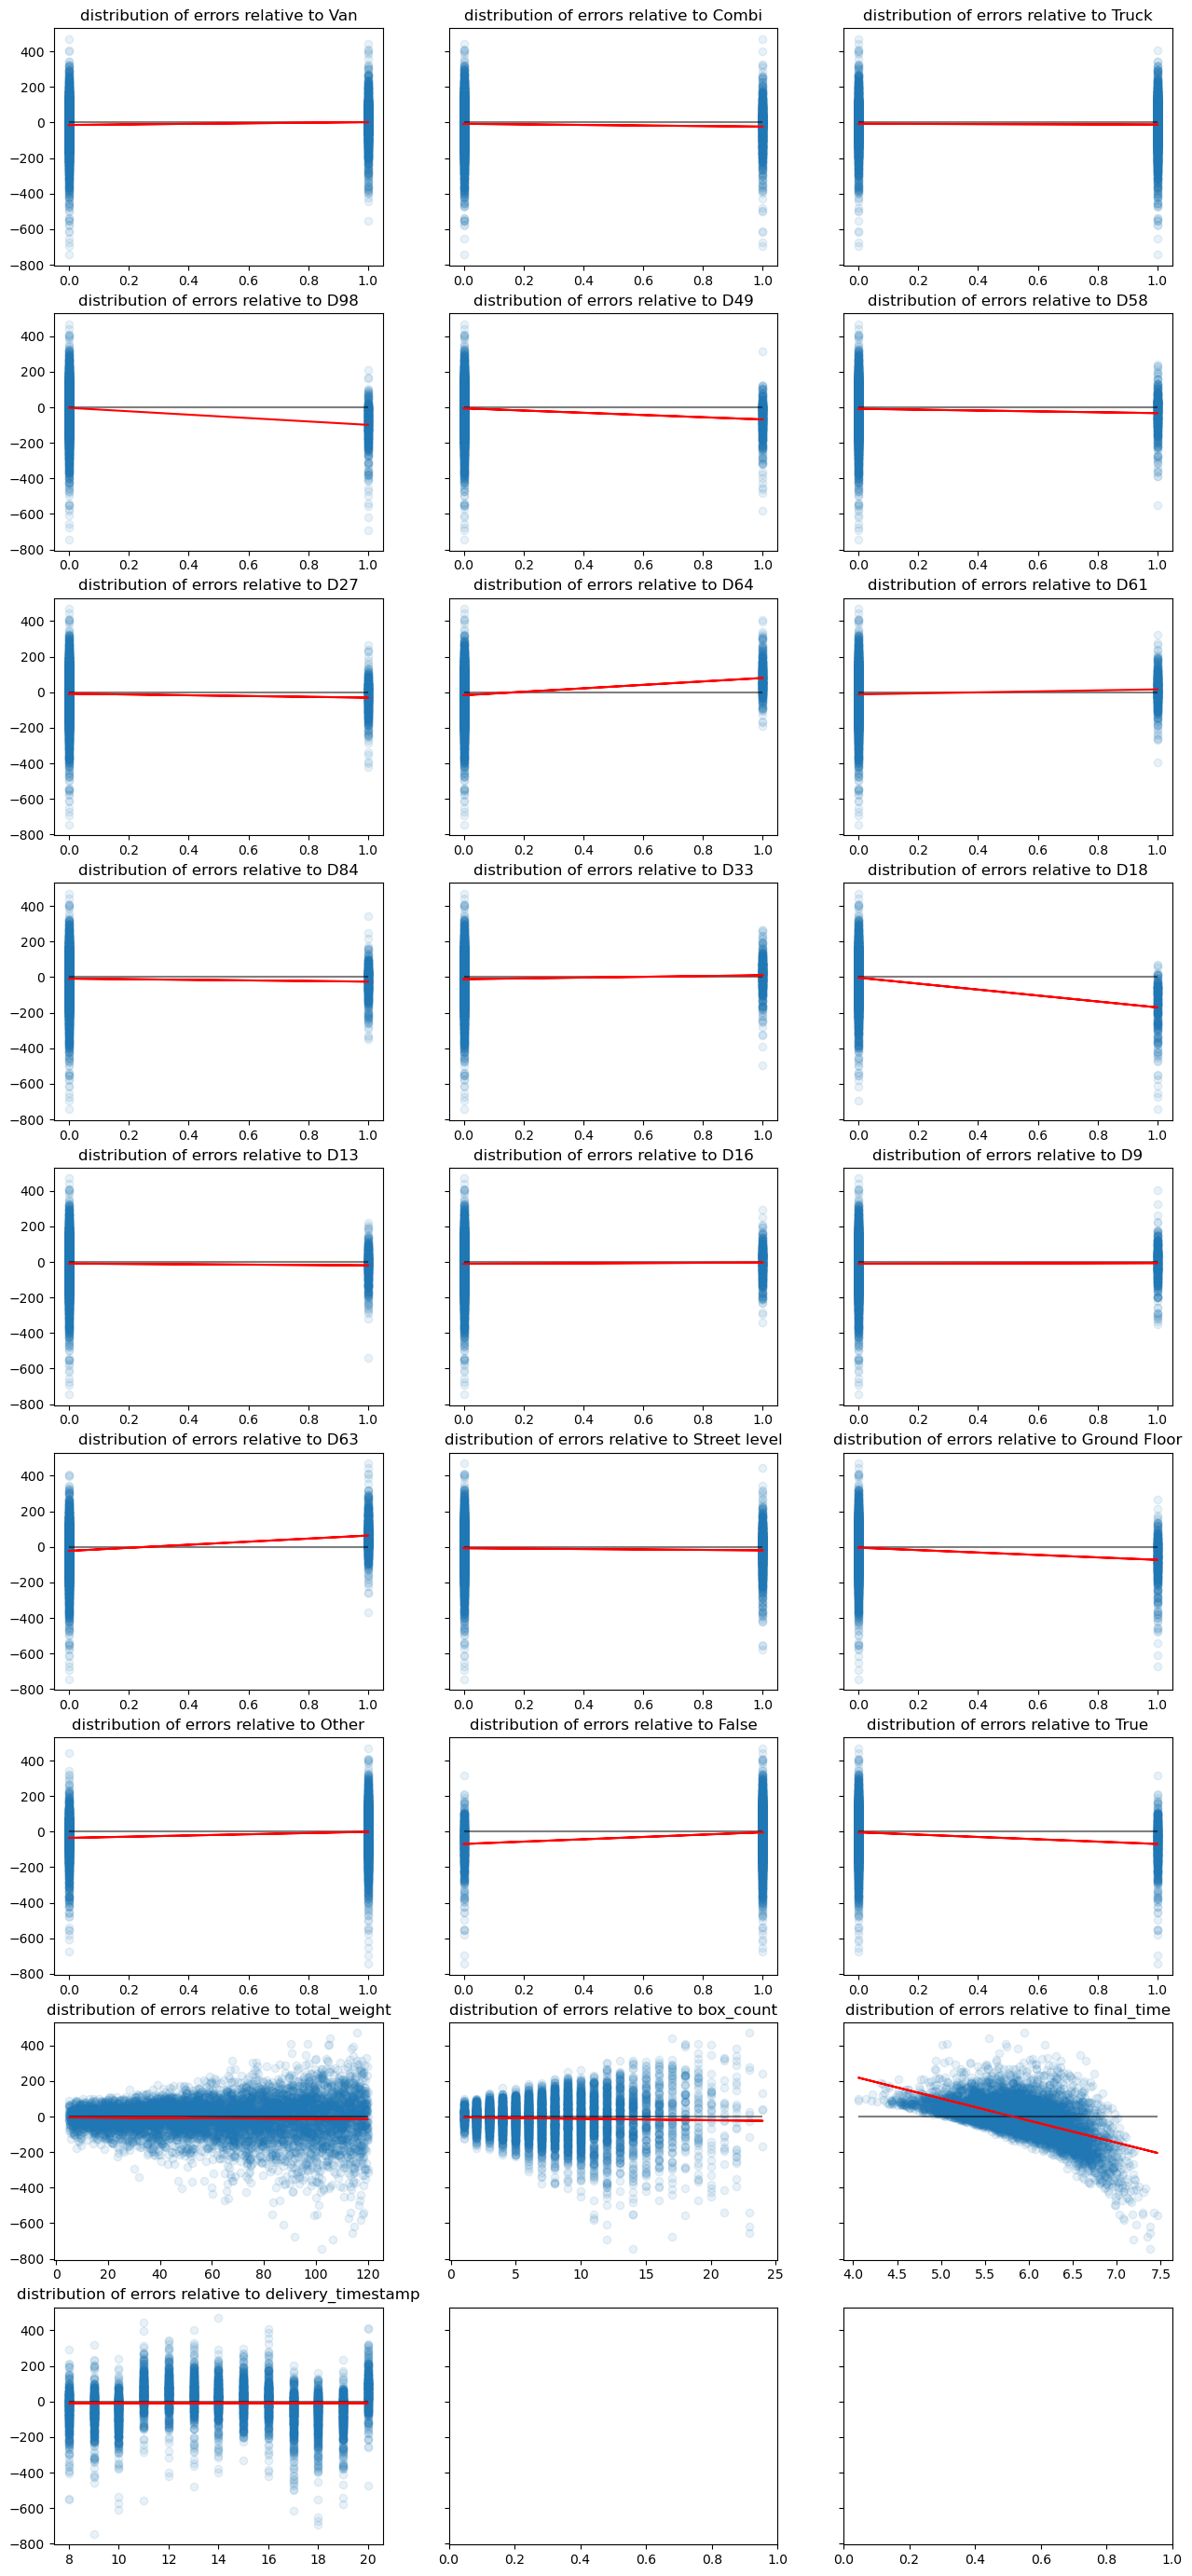

In [1638]:
SanityCheck(svm_reg).plot_errors()

In [1682]:
train_and_test = pd.concat([train.copy(), test.copy()])
final_prepared = pd.DataFrame(full_pipeline.fit_transform(train_and_test))

In [1683]:
testy = final_prepared.iloc[7200:,23]
testX = final_prepared.iloc[7200:,:].drop(23, axis = 1)

trainy = final_prepared.iloc[:7200,23]
trainX = final_prepared.iloc[:7200,:].drop(23, axis = 1)

In [1662]:
testy.head()

7200    5.805135
7201    5.749393
7202    6.714171
7203    5.693732
7204    6.163315
Name: 23, dtype: float64

In [1661]:
testX.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,24
7200,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,80.63,7.0,15.0
7201,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,95.97,11.0,13.0
7202,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,96.36,12.0,8.0
7203,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,49.10,4.0,17.0
7204,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,104.21,20.0,19.0


In [1688]:
print(f"test: {np.abs(np.exp(tree_reg.predict(testX)) - np.exp(testy)).mean()}, \ntrain: {np.abs(np.exp(tree_reg.predict(trainX)) - np.exp(trainy)).mean()}")

test: 63.77111647370184, 
train: 45.33549734856266


In [1690]:
print(f"test: {np.abs(np.exp(svm_reg.predict(testX)) - np.exp(testy)).mean()}, \ntrain: {np.abs(np.exp(svm_reg.predict(trainX)) - np.exp(trainy)).mean()}")

test: 75.73188909467433, 
train: 78.34992244940902


In [1689]:
print(f"test: {np.abs(np.exp(forest_reg.predict(testX)) - np.exp(testy)).mean()}, \ntrain: {np.abs(np.exp(forest_reg.predict(trainX)) - np.exp(trainy)).mean()}")

test: 57.49014511402092, 
train: 50.51155630812628


In [1673]:
np.abs(np.exp(tree_reg.predict(testX)) - np.exp(testy)).describe()

count    1800.000000
mean       63.771116
std        70.528842
min         0.000000
25%        17.222467
50%        40.923900
75%        86.029327
max       550.197062
Name: 23, dtype: float64

In [1674]:
np.abs(np.exp(forest_reg.predict(testX)) - np.exp(testy)).describe()

count    1800.000000
mean       57.490145
std        63.628584
min         0.024185
25%        17.879256
50%        38.628039
75%        72.016587
max       495.142769
Name: 23, dtype: float64

In [1675]:
np.abs(np.exp(svm_reg.predict(testX)) - np.exp(testy)).describe()

count    1800.000000
mean       75.731889
std        70.913589
min         0.002386
25%        26.258114
50%        54.217270
75%       104.624582
max       517.648439
Name: 23, dtype: float64